In [95]:
import csv
import collections
import itertools
import nltk
from nltk.corpus import stopwords
sw = stopwords.words('english')
sw.append('gitsvnid')
from nltk.stem import PorterStemmer
ps = PorterStemmer()
import string
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [15, 10]

In [96]:
def clean_text(words):
    #convert to lower case
    words = [w.lower() for w in words]
    #remove links, hashcode, etc. based on their length
    words = [w for w in words if len(w) < 20]
    #remove punctuation
    for i in range(len(words)):
        words[i] = words[i].translate(str.maketrans('', '', string.punctuation))
    #remove empty string
    words = [w for w in words if len(w) > 0]
    #remove stop words
    words = [w for w in words if w not in sw]
    #remove words contain numbers since they normally are not meaningful
    words = [w for w in words if not any(l.isdigit() for l in w)]
    return words

In [97]:
def find_keywords(list1, list2, n):
    #n is the number of keywords
    counter1 = collections.Counter(list1)
    counter2 = collections.Counter(list2)
    dict1 = counter1.most_common(n)
    dict2 = counter2.most_common(n)
    keywords1 = [tupel[0] for tupel in dict1]
    keywords2 = [tupel[0] for tupel in dict2]
    keywords = list(set(keywords1 + keywords2))
    #find the stem of keywords (plurals, participles)
    keywords_stem = []
    for w in keywords:
        if ps.stem(w) not in keywords_stem:
            keywords_stem.append(ps.stem(w))
    return keywords_stem

In [98]:
def is_element(word, sentence):
    words = sentence.split()
    stemming_words = [ps.stem(w) for w in words]
    if ps.stem(word) in stemming_words:
        return True
    else:
        return False

In [99]:
def count_frequency(word, words_list):
    n = len(words_list)
    occ = 0.0
    for w in words_list:
        if ps.stem(w) == word:
            occ = occ + 1
    frq = occ / n
    return frq

In [100]:
def test(message, keywords, frq_quality, frq_not_quality):
    words = message.split()
    eff_words = clean_text(words)
    p_quality = 0
    p_not_quality = 0
    for i in eff_words:
        if i in keywords:
            p_quality = p_quality + frq_quality[keywords.index(i)]
            p_not_quality = p_not_quality + frq_not_quality[keywords.index(i)]
    if p_quality > p_not_quality:
        return True
    else:
        return False

In [101]:
#load in data and distribute marked commits into two lists. 
#One list contains the messages of commits which improve internal quality, 
#the other contains those of commits which are not meant for internal quality improving.

In [102]:
commits_quality_all = []
commits_not_quality_all = []

In [103]:
with open("output_320000.csv", 'r', encoding='UTF-8') as f:
    reader = csv.reader(f)
    for row in reader:
        if (row[-1] == 'True'):
            commits_quality_all.append(row[1])
        if (row[-1] == 'False'):
            commits_not_quality_all.append(row[1])

In [104]:
#N = 100

In [105]:
N = 20

In [106]:
#Select N messages (samples) for feature extraction randomly. 
#The others will be used for parameter optimization and performance assessment.

In [107]:
index_quality_sample = np.random.randint(len(commits_quality_all),size = N)
index_quality_test = np.array([i for i in np.arange(len(commits_quality_all)) if i not in index_quality_sample])
index_not_quality_sample = np.random.randint(len(commits_not_quality_all), size = N)
index_not_quality_test = np.array([i for i in np.arange(len(commits_not_quality_all)) if i not in index_not_quality_sample])

In [108]:
commits_quality = [commits_quality_all[i] for i in index_quality_sample]
commits_not_quality = [commits_not_quality_all[i] for i in index_not_quality_sample]

In [109]:
#Create a list of all words in  all messages.

In [110]:
words_quality = list(itertools.chain(*[commit.split() for commit in commits_quality]))
words_not_quality = list(itertools.chain(*[commit.split() for commit in commits_not_quality]))

In [111]:
#Some clean up (punctuation, stop words, etc.).

In [112]:
eff_words_quality = clean_text(words_quality)
eff_words_not_quality = clean_text(words_not_quality)

An example to demonstrate decision tree

In [113]:
samples = commits_quality + commits_not_quality
values = np.concatenate((np.ones(N), np.zeros(N)))

In [114]:
n_keywords = 40

In [115]:
keywords = find_keywords(eff_words_quality, eff_words_not_quality, n_keywords)

Training Matrix

In [116]:
training_matrix = np.zeros((2 * N, len(keywords)))
for i in range(2 * N):
    for j in range(len(keywords)):
        if is_element(keywords[j], samples[i]):
            training_matrix[i][j] = 1

form decision tree

In [125]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [126]:
iris = load_iris()
x = iris.data[:, 2:]
y = iris.target

In [127]:
tree_clf = DecisionTreeClassifier(max_depth = 2)
tree_clf.fit(x, y)

DecisionTreeClassifier(max_depth=2)

In [136]:
export_graphviz( tree_clf, 
                out_file="iris_tree.dot",
                feature_names=iris.feature_names[2:], 
                class_names=iris.target_names, 
                rounded=True, 
                filled=True)

In [137]:
x = training_matrix
y = values

In [138]:
tree_clf = DecisionTreeClassifier(max_depth = 10)
tree_clf.fit(x, y)

DecisionTreeClassifier(max_depth=10)

In [140]:
export_graphviz(tree_clf, 
                out_file = "tree.dot",
               feature_names = keywords,
               class_names = ["not quality improving", "quality improving"],
               rounded = True,
               filled = True)

In [121]:
x[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [123]:
tree_clf.predict_proba([x[0]])

array([[0., 1.]])

In [124]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [93]:
#Determine the number of keywords, which gives the best performance 

In [117]:
n_keywords = np.linspace(1, min(len(eff_words_quality), len(eff_words_not_quality))/10, 20, dtype = 'int')
acc = np.zeros(len(n_keywords))

In [118]:
for i in range(len(n_keywords)):
    keywords = find_keywords(eff_words_quality, eff_words_not_quality, n_keywords[i])
    frq_quality = np.zeros(len(keywords))
    frq_not_quality = np.zeros(len(keywords))
    for j in range(len(keywords)):
        frq_quality[j] = count_frequency(keywords[j], eff_words_quality)
        frq_not_quality[j] = count_frequency(keywords[j], eff_words_not_quality)
    n_corr = 0.0
    for k in range(len(index_quality_test)):
        message_test = commits_quality_all[index_quality_test[k]]
        if test(message_test, keywords, frq_quality, frq_not_quality):
            n_corr = n_corr + 1
    for l in range(len(index_not_quality_test)):
        message_test = commits_not_quality_all[index_not_quality_test[l]]
        if not test(message_test, keywords, frq_quality, frq_not_quality):
            n_corr = n_corr + 1
    acc[i] = n_corr / (len(index_quality_test) + len(index_not_quality_test))   

'\nx = np.arange(len(keywords))\nwidth = 0.35\n\nfig, ax = plt.subplots()\nax.bar(x - width/2, frq_quality, width, label = "quality")\nax.bar(x + width/2, frq_not_quality, width, label = "not quality")\nax.set_xticks(x)\nax.set_xticklabels(keywords)\nax.legend()\nplt.show()\n'

In [123]:
acc

array([0.67805295, 0.61357814, 0.64560205, 0.63620837, 0.63407344,
       0.6323655 , 0.6323655 , 0.63364646, 0.63919727, 0.63791631,
       0.63706234, 0.63706234, 0.63663535, 0.63919727, 0.63962425,
       0.63962425, 0.64047822, 0.64047822, 0.64133219, 0.64133219])

In [124]:
n_keywords

array([ 1,  3,  6,  9, 12, 15, 17, 20, 23, 26, 29, 31, 34, 37, 40, 43, 46,
       48, 51, 54])

Text(0, 0.5, 'accuracy')

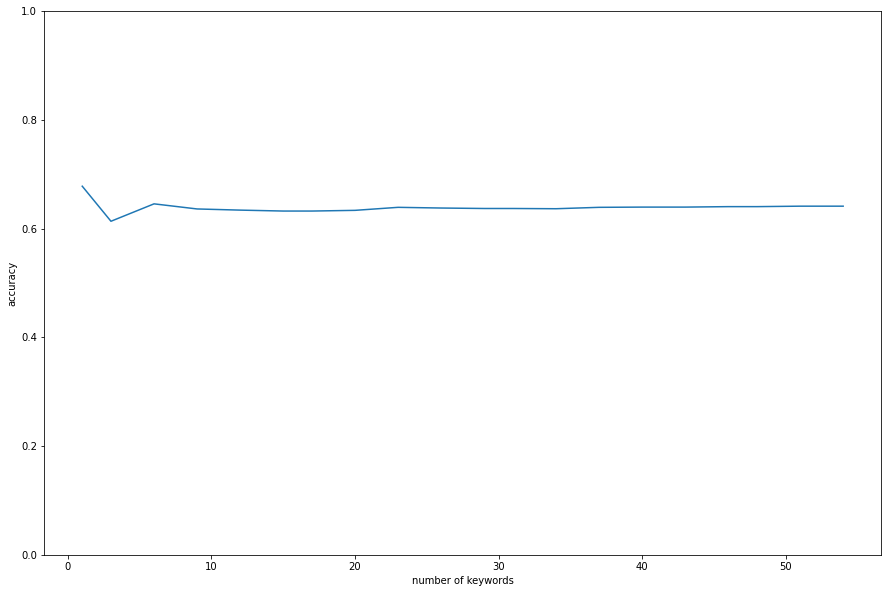

In [125]:
fig, ax = plt.subplots()
ax.plot(n_keywords, acc)
ax.set_ylim(0,1)
ax.set_xlabel("number of keywords")
ax.set_ylabel("accuracy")

In [127]:
#demonstrate example with n_kwds

In [136]:
n_kwds = 10

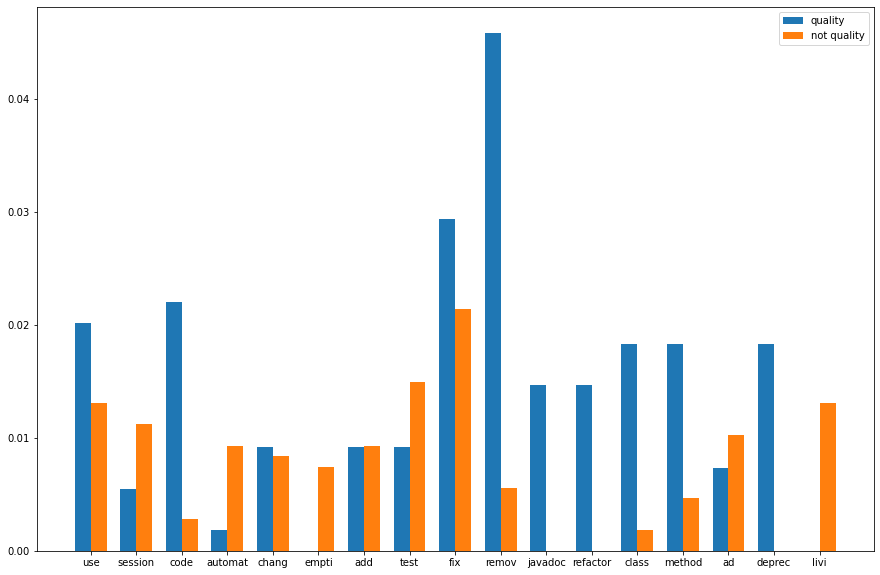

In [137]:
keywords = find_keywords(eff_words_quality, eff_words_not_quality, n_kwds)
frq_quality = np.zeros(len(keywords))
frq_not_quality = np.zeros(len(keywords))
for j in range(len(keywords)):
    frq_quality[j] = count_frequency(keywords[j], eff_words_quality)
    frq_not_quality[j] = count_frequency(keywords[j], eff_words_not_quality)

x = np.arange(len(keywords))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, frq_quality, width, label = "quality")
ax.bar(x + width/2, frq_not_quality, width, label = "not quality")
ax.set_xticks(x)
ax.set_xticklabels(keywords)
ax.legend()
plt.show()

In [138]:
#Anforderungen für Modell Einsatz:
#1. Die Commits sollen kurz angefasst werden. Damit erleichtet die Suche nach Stichwort.
#  
#2. 

In [ ]:
#Verbesserungsmöglichkeiten:
#1. Die Commits, die als Probe gewählt wurden, könnten weiter analysiert werden.
#2. Es könnte mehrmals durchlaufen lassen, für features extraction
#3. 